In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Подготовим данные к анализу

In [19]:
df = pd.read_excel('Sales.xls')
df.columns = df.loc[3]
df.drop(df.index[0:4], inplace = True)
df = df.reset_index(drop = True)
df.drop([15578], inplace = True)
df['Время'] = pd.to_datetime(df['Время'], errors = 'coerce')
df['Сумма'] = df['Сумма'].str.replace(' ', '')
df['Сумма'] = df['Сумма'].str.replace('\xa0', '')
df['Сумма'] = df['Сумма'].str.replace('\t', '')
df['Сумма'] = df['Сумма'].str.replace(',', '.')
df['Сумма'] = pd.to_numeric(df['Сумма'])
df.head()

/tmp/ipython-input-57022637.py:6: UserWarning: Parsing dates in %d.%m.%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Время'] = pd.to_datetime(df['Время'], errors = 'coerce')


3,Тип документа,№,Пров.,Время,Сумма,Валюта,Со склада,На склад,Организация,Контрагент,Статус,Комментарий
0,Выплата,00268,Да,2025-09-24 21:21:00,24549.0,руб,NaN,NaN,semakind587,Администратор,NaN,Выплата денег при закрытии смены
1,Розничная продажа,07690,Да,2025-09-24 21:14:00,200.0,руб,Основной склад,NaN,semakind587,Розничный покупатель,NaN,NaN
2,Розничная продажа,07689,Да,2025-09-24 21:12:00,2180.0,руб,Основной склад,NaN,semakind587,Розничный покупатель,NaN,NaN
3,Розничная продажа,07688,Да,2025-09-24 20:36:00,500.0,руб,Основной склад,NaN,semakind587,Розничный покупатель,NaN,NaN
4,Розничная продажа,07687,Да,2025-09-24 19:27:00,450.0,руб,Основной склад,NaN,semakind587,Розничный покупатель,NaN,NaN


Поскольку, со слов заказчика, реальный смысл имеют только данные розничной продажи, анализировать будем именно их. Для начала посмотрим общее распределение.


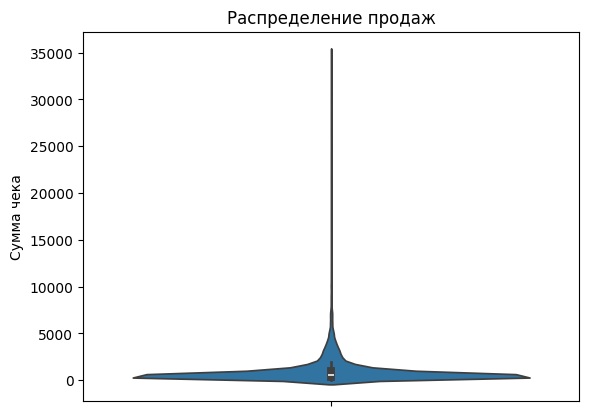

In [20]:
df = df[df['Тип документа'] == 'Розничная продажа'][['Время', 'Сумма']]
df = df.reset_index(drop = True)

sns.violinplot(data = df, y = 'Сумма')
plt.title('Распределение продаж')
plt.ylabel('Сумма чека')
plt.show()

Основной чек от 0 до 2000. Исследуем распределение подробнее в этом диапазоне.

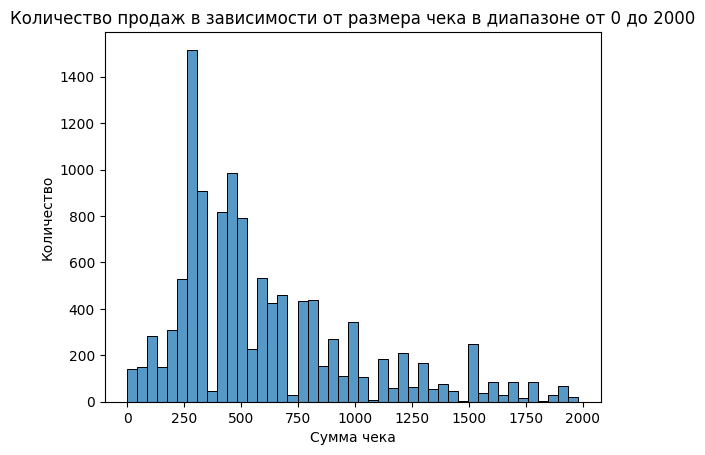

In [21]:
sns.histplot(data = df[df['Сумма'] < 2000], x = 'Сумма')
plt.title('Количество продаж в зависимости от размера чека в диапазоне от 0 до 2000')
plt.xlabel('Сумма чека')
plt.ylabel('Количество')
plt.show()

Самый популярный чек - 250-300 рублей. То есть клиент покупает одну жидкость и уходит. Возможно стоит предложить скидку при покупке второй или третьей позиции.

Теперь проведём более детальный анализ. Для этого добавим флаг часа, дня недели, дня, месяца, квартала и года

In [5]:
df['Дата'] = df['Время'].dt.date
df['Час'] = df['Время'].dt.hour
df['День недели'] = df['Время'].dt.day_of_week
df['День'] = df['Время'].dt.day
df['Месяц'] = df['Время'].dt.month
df['Год'] = df['Время'].dt.year
df.head()

3,Время,Сумма,Дата,Час,День недели,День,Месяц,Год
0,2025-09-24 21:14:00,200.0,2025-09-24,21,2,24,9,2025
1,2025-09-24 21:12:00,2180.0,2025-09-24,21,2,24,9,2025
2,2025-09-24 20:36:00,500.0,2025-09-24,20,2,24,9,2025
3,2025-09-24 19:27:00,450.0,2025-09-24,19,2,24,9,2025
4,2025-09-24 19:25:00,2500.0,2025-09-24,19,2,24,9,2025


Посмотрим зависимость выручки от дня недели.

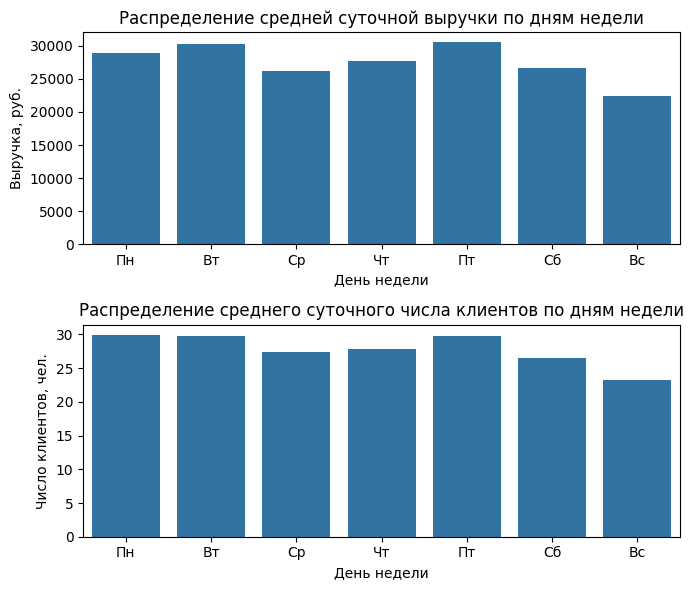

In [6]:
day_of_week_data = df.groupby('Дата', as_index = False)['Сумма'].agg(['sum', 'count'])
day_of_week_data['Дата'] = pd.to_datetime(day_of_week_data['Дата'])
day_of_week_data['День недели'] = day_of_week_data['Дата'].dt.day_of_week
day_of_week_data = day_of_week_data.groupby('День недели', as_index = False)[['sum', 'count']].mean()
days_of_week_ru = {
    0: 'Пн', 1: 'Вт', 2: 'Ср', 3: 'Чт', 4: 'Пт', 5: 'Сб', 6: 'Вс'
}
day_of_week_data['День недели'] = day_of_week_data['День недели'].map(days_of_week_ru)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (7, 6))

sns.barplot(data = day_of_week_data, x = 'День недели', y = 'sum', ax = ax1)
ax1.set_title('Распределение средней суточной выручки по дням недели')
ax1.set_ylabel('Выручка, руб.')

sns.barplot(data = day_of_week_data, x = 'День недели', y = 'count', ax = ax2)
ax2.set_title('Распределение среднего суточного числа клиентов по дням недели')
ax2.set_ylabel('Число клиентов, чел.')

plt.tight_layout()
plt.show()

В воскресенье продажи проседают. Это может быть связано либо с графиком работы магазина, либо с тем, что в воскресенье люди не хотят тратить время на поход в магазин. Проверим эту гипотезу позже.

Теперь посмотрим зависимость прожаж от времени суток.

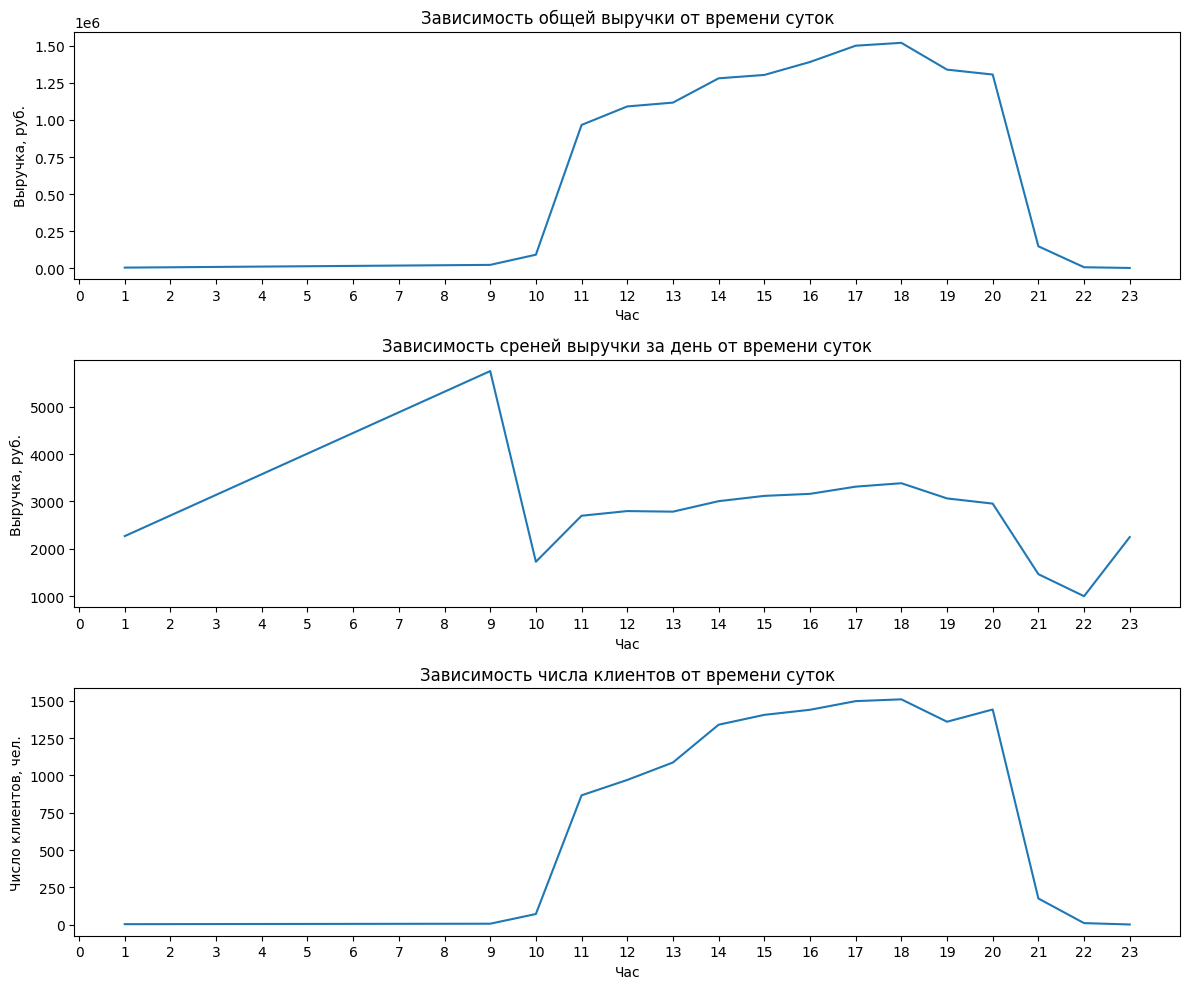

In [7]:
hour_data = df.groupby('Час', as_index = False).agg({'Сумма' : 'sum', 'Дата' : 'nunique'})
hour_data['Дата'] = hour_data['Сумма'] / hour_data['Дата']
hour_data.columns = ['Час', 'sum', 'mean']

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (12, 10))

sns.lineplot(data = hour_data, x = 'Час', y = 'sum', ax = ax1)
ax1.set_title('Зависимость общей выручки от времени суток')
ax1.set_ylabel('Выручка, руб.')
ax1.set_xticks(range(0, 24))

sns.lineplot(data = hour_data, x = 'Час', y = 'mean', ax = ax2)
ax2.set_title('Зависимость среней выручки за день от времени суток')
ax2.set_ylabel('Выручка, руб.')
ax2.set_xticks(range(0, 24))

hour_df = df.groupby('Час', as_index = False)['Сумма'].count()
sns.lineplot(data = hour_df, x = 'Час', y = 'Сумма', ax = ax3)
ax3.set_title('Зависимость числа клиентов от времени суток')
ax3.set_ylabel('Число клиентов, чел.')
ax3.set_xticks(range(0, 24))

plt.tight_layout()
plt.show()

С 10 до 22 графики совпадают, скорее всего, это - рабочие часы. Остальные часы не несут практически значимой информации. С 10 до 11 и с 20 до 22 выручка меньше среднего значения. Рекомендованный график работы: 10:00 - 21:00.

В 18 часов характерный пик, соответствующий времени, когда люди возвращаются с работы. Но он слишком слабовыраженный, можно предположить, что основная клиентская аудитория - неработающие люди (студенты). Стоит привлечь более взрослую, зачастую более платёжеспособную аудиторию. Имеет резон расширить ассортимет, добавив позиции, ориентированные на возрастную аудиторию - HQD, табак, кальяны. Вероятно, возрастная аудитория просто не знает о магазине, так как сарафанное радио проходит мимо них. Возможно, стоит провести рекламную кампанию, ориентированную на взрослых, работающих людей. Стоит расчитать NPV, но требуется больше данных

Наконец, исследуем кореляцию времени суток и дня недели

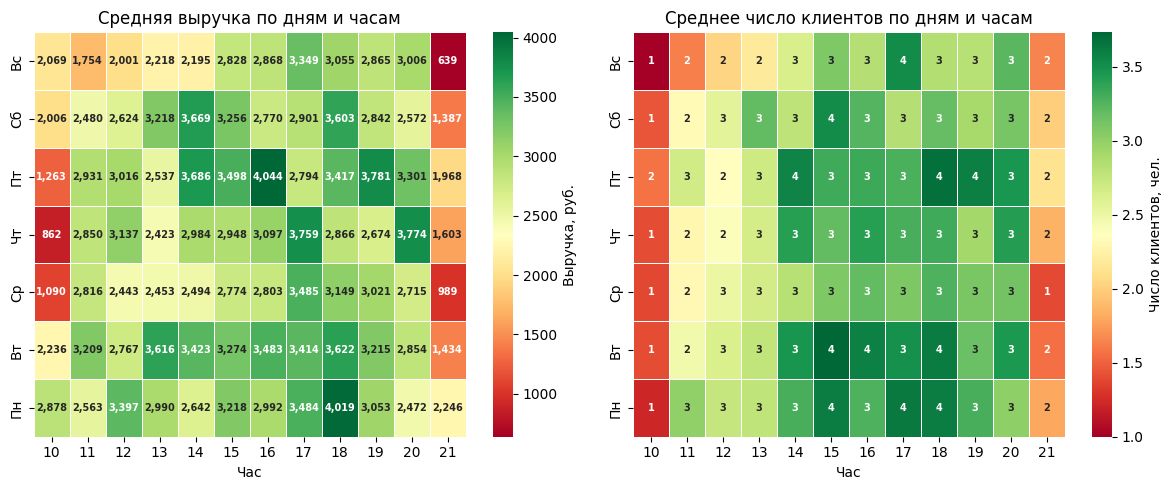

In [8]:
pivot_data = df[df['Час'].isin(range(10, 22))].groupby(['Дата', 'Час'], as_index = False)['Сумма'].agg(['sum', 'count'])
pivot_data['День недели'] = pd.to_datetime(pivot_data['Дата']).dt.day_of_week

pivot_table_sum = pivot_data.pivot_table(values = 'sum', index = 'День недели', columns = 'Час')
pivot_table_count = pivot_data.pivot_table(values = 'count', index = 'День недели', columns = 'Час')
pivot_table_sum.index = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
pivot_table_count.index = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
pivot_table_sum = pivot_table_sum.iloc[::-1]
pivot_table_count = pivot_table_count.iloc[::-1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

sns.heatmap(pivot_table_sum, cmap = 'RdYlGn', annot = True, fmt = ',.0f', annot_kws = {'size' : 7, 'weight' : 'bold'},
            linecolor = 'white', linewidths = 0.5, cbar_kws = {'label' : 'Выручка, руб.', 'shrink' : 1}, ax = ax1)
ax1.set_title('Средняя выручка по дням и часам')

sns.heatmap(pivot_table_count, cmap = 'RdYlGn', annot = True, fmt = ',.0f', annot_kws = {'size' : 7, 'weight' : 'bold'},
            linecolor = 'white', linewidths = 0.5, cbar_kws = {'label' : 'Число клиентов, чел.', 'shrink' : 1}, ax = ax2)
ax2.set_title('Среднее число клиентов по дням и часам')

plt.tight_layout()
plt.show()

Ранее мы предположили, что падение выручки в воскресенье связано с изменённым графиком работы - гипотеза не подтвердилась. Значит, нужно замотивировать клиентов посещать магазин даже в воскресенье. Например, улучшить рекреационную зону (PS, диван), добавить музыку, кальян, провести рекламную кампанию с упором на уютную, благоприятную для отдыха атмосферу, организовать по воскресеньям соревнования по киберспорту и прочие активности.

Также можно заметить, что прибыль с 10 до 11 и с 20 до 21 настолько мала, что может не покрывать комунальные расходы и зарплату продавцу. Этот момент также будет обговорён с заказчиком.

Теперь посмотрим зависимость выручки от порядкогого номера дня в месяце от 0 до 31.

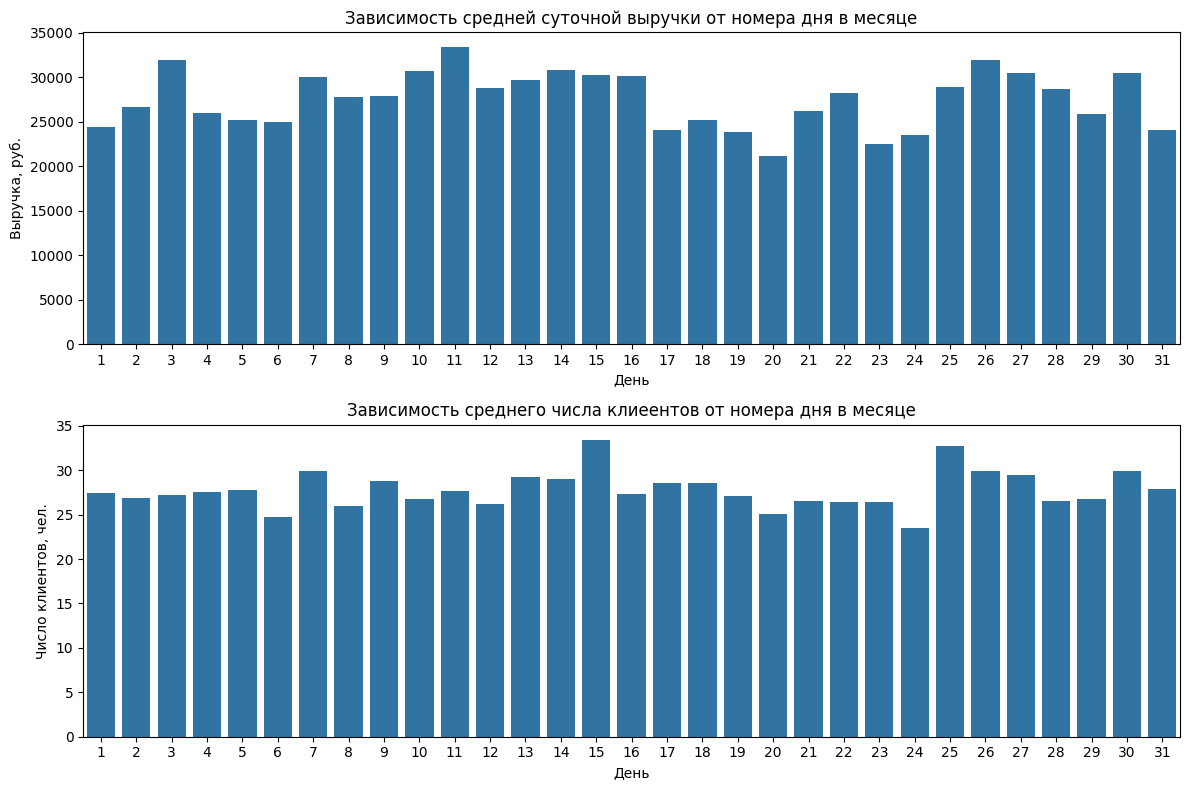

In [9]:
day_data = df.groupby('Дата', as_index = False)['Сумма'].agg(['sum', 'count'])
day_data['День'] = pd.to_datetime(day_data['Дата']).dt.day
Day_data = day_data.groupby('День', as_index = False)[['sum', 'count']].mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 8))

sns.barplot(data = Day_data, x = 'День', y = 'sum', ax = ax1)
ax1.set_title('Зависимость средней суточной выручки от номера дня в месяце')
ax1.set_ylabel('Выручка, руб.')

sns.barplot(data = Day_data, x = 'День', y = 'count', ax = ax2)
ax2.set_title('Зависимость среднего числа клиеентов от номера дня в месяце')
ax2.set_ylabel('Число клиентов, чел.')

plt.tight_layout()
plt.show()

Даже с учётом того, что не все месяцы имеют 31 день, график средней суточной выручки слишком ломанный по всей длине. Скорее всего, большую роль сыграло то, на какие дни недели выпали те или другие дни месяца. Проверим.

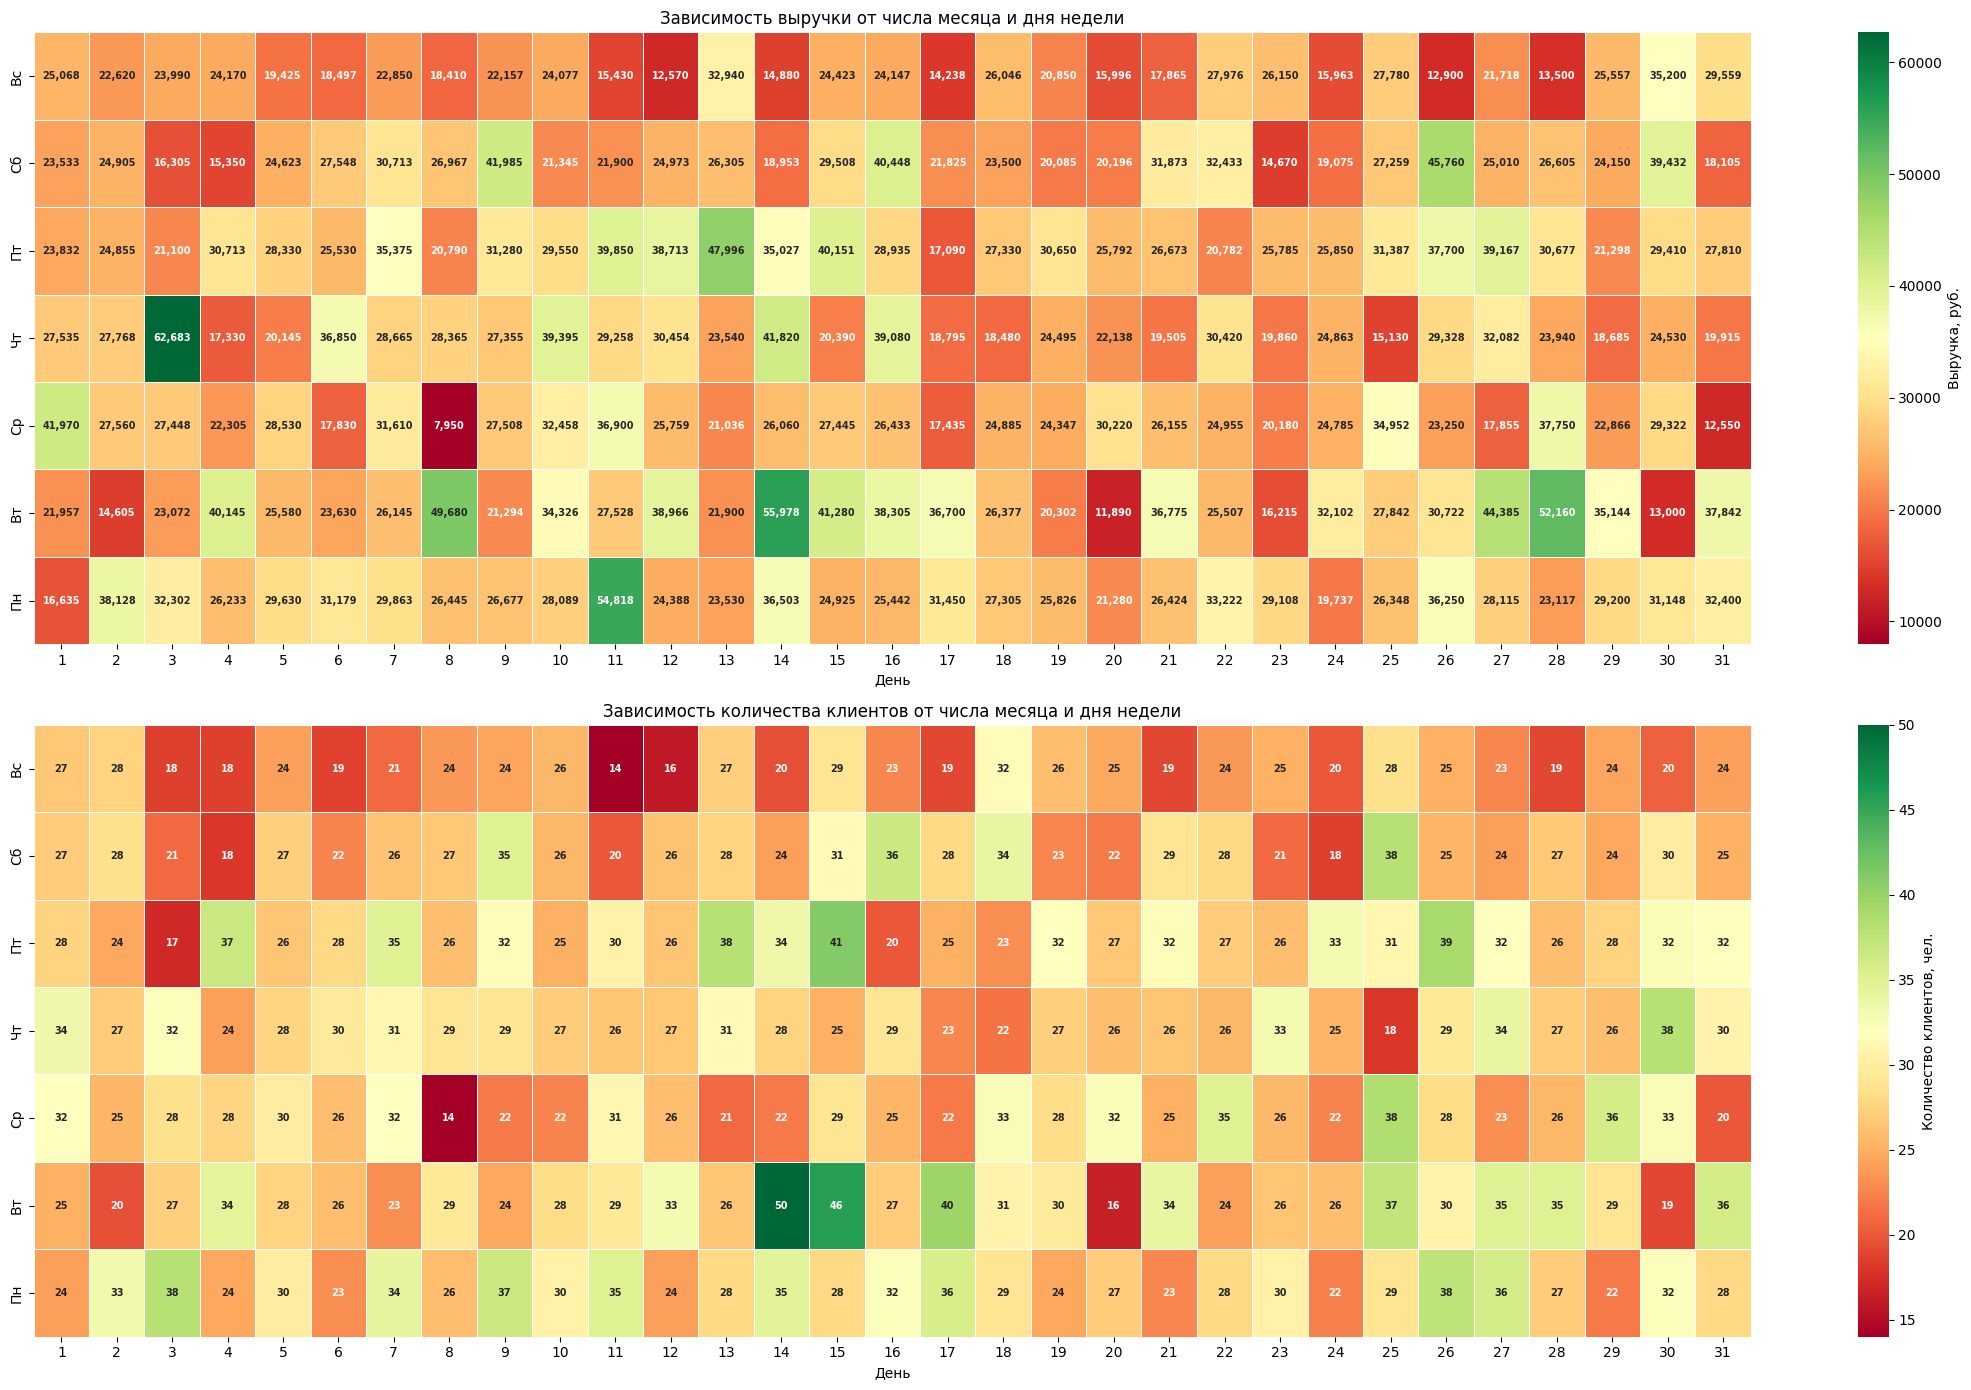

In [11]:
day_data['День недели'] = pd.to_datetime(day_data['Дата']).dt.day_of_week
day_pivot_table_sum = day_data.pivot_table(values = 'sum', index = 'День недели', columns = 'День')
day_pivot_table_count = day_data.pivot_table(values = 'count', index = 'День недели', columns = 'День')
day_pivot_table_sum.index = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
day_pivot_table_count.index = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
day_pivot_table_sum = day_pivot_table_sum.iloc[::-1]
day_pivot_table_count = day_pivot_table_count.iloc[::-1]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (22, 14))

sns.heatmap(day_pivot_table_sum, cmap = 'RdYlGn', annot = True, fmt = ',.0f', annot_kws = {'size' : 7, 'weight' : 'bold'},
            linecolor = 'white', linewidths = 0.5, cbar_kws = {'label' : 'Выручка, руб.', 'shrink' : 1}, ax = ax1)
ax1.set_title('Зависимость выручки от числа месяца и дня недели')

sns.heatmap(day_pivot_table_count, cmap = 'RdYlGn', annot = True, fmt = ',.0f', annot_kws = {'size' : 7, 'weight' : 'bold'},
            linecolor = 'white', linewidths = 0.5, cbar_kws = {'label' : 'Количество клиентов, чел.', 'shrink' : 1}, ax = ax2)
ax2.set_title('Зависимость количества клиентов от числа месяца и дня недели')

plt.tight_layout()
plt.show()


Тепловая карта показывает такую-же тенденцию, как и первоначальный график. Пик в 10-16 и 26-28 числах и провалы в 4-9 и 17-24. При этом отличается не столько число клиентов, сколько их средний чек. Возможно, это связанно с финансовым положением клиентов (аванс, зарплата, стипендия) либо с днями закупок самого магазина - в провальные числа клиенты готовы купить товар, но его попрасту нет. Если же поставки нового товара не привязанны к определённым датам, тогда имеет смысл делать крупные закупки перед пиковыми днями, чтобы гарантированно удовлетворить спрос.

Наконец, исследуем сезонность магазина и отследим общую тенденцию развития.

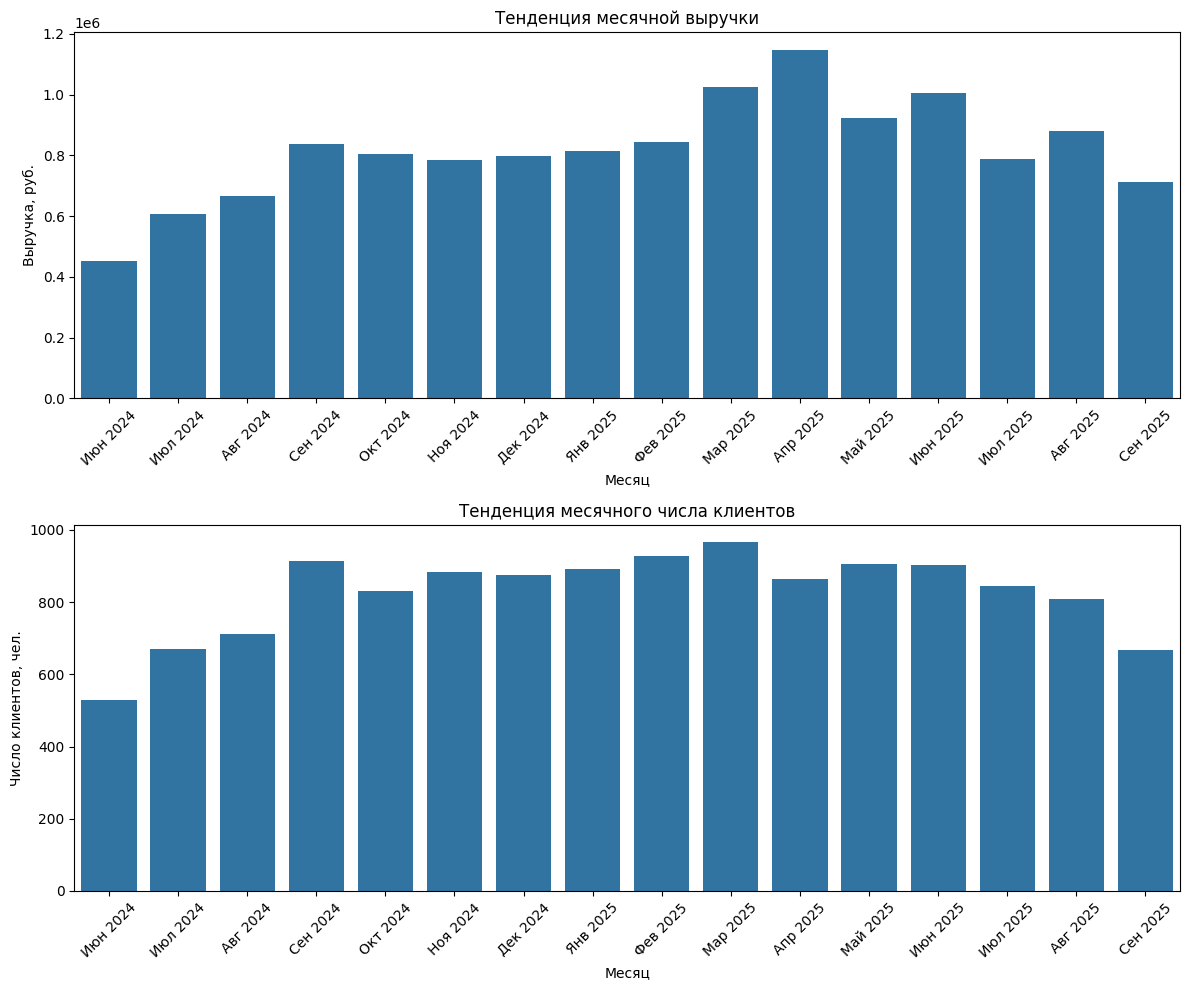

In [12]:
month_data = df.groupby(['Год', 'Месяц'], as_index = False)['Сумма'].agg(['sum', 'count'])
months_ru = {
    1: 'Янв', 2: 'Фев', 3: 'Мар', 4: 'Апр', 5: 'Май', 6: 'Июн',
    7: 'Июл', 8: 'Авг', 9: 'Сен', 10: 'Окт', 11: 'Ноя', 12: 'Дек'
}
month_data['Месяц'] = month_data['Месяц'].map(months_ru) + ' ' + month_data['Год'].astype(str)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (12, 10))

sns.barplot(data = month_data, x = 'Месяц', y = 'sum', ax = ax1)
ax1.tick_params(axis = 'x', rotation=45)
ax1.set_ylabel('Выручка, руб.')
ax1.set_title('Тенденция месячной выручки')

sns.barplot(data = month_data, x = 'Месяц', y = 'count', ax = ax2)
ax2.tick_params(axis = 'x', rotation=45)
ax2.set_ylabel('Число клиентов, чел.')
ax2.set_title('Тенденция месячного числа клиентов')

plt.tight_layout()
plt.show()

Наблюдается ярковыраженный пик прибыли с марта по июнь. Если в это время была изменена политика поставок или проведена рекламная кампания, можно оценить их благоприятное влияние. Если же нет, то можно сделать выводы о сезонности магазина. С марта по июнь люди больше гуляют на улице и больше склонны к трате денег, отсюда и рост прибыли. В июле и августе улетают в отпуск, как следствие - просадка. Заказчику стоит совершать крупные закупки в начале марта. Можно закупить и товар премиум качества.

Сентябрь 2025 просел из-за неполноты данных. В целом, тенденция положительная, виден рост прибыли.

Под конец, исследуем выбросы. Посмотрим 20 самых высоких и 20 самых низких касс за день.

In [13]:
day_data['Месяц'] = pd.to_datetime(day_data['Дата']).dt.month
day_data['Год'] = pd.to_datetime(day_data['Дата']).dt.year
day_data['День недели'] = pd.to_datetime(day_data['Дата']).dt.day_of_week
day_data.sort_values('sum').tail(20)

,Дата,sum,count,День,День недели,Месяц,Год
235,2025-01-28,52160.00,35,28,1,1,2025
265,2025-02-27,52220.00,47,27,3,2,2025
466,2025-09-16,52600.00,33,16,1,9,2025
308,2025-04-11,52750.00,33,11,4,4,2025
306,2025-04-09,54175.00,27,9,2,4,2025
435,2025-08-16,55250.00,30,16,5,8,2025
81,2024-08-27,55400.00,40,27,1,8,2024
221,2025-01-14,55977.99,50,14,1,1,2025
155,2024-11-09,56040.00,41,9,5,11,2024
355,2025-05-28,58600.00,30,28,2,5,2025


Сразу можно заметить, что рекордные кассы бывают вблизи крупных праздников - 27 декабря, 7 марта, 27 февраля. Взглянем подрoбнее на зависимость количества рекордных касс от различных параметров.

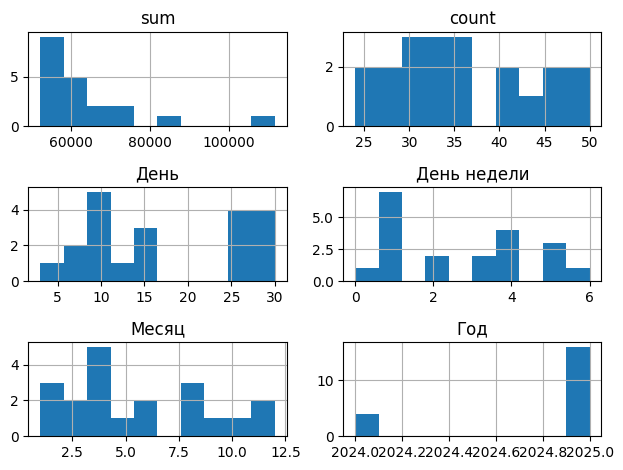

In [14]:
day_data.sort_values('sum').tail(20).hist()
plt.tight_layout()
plt.show()

Наблюдаем всё ту же интересную статистику - провал в июле и августе, пик в 10-15, 25-30 числа, провал в 16-24 числа.

Теперь 20 самых низких касс.

In [15]:
day_data.sort_values('sum').head(20)

,Дата,sum,count,День,День недели,Месяц,Год
358,2025-05-31,7300.0,15,31,5,5,2025
25,2024-07-02,7770.0,15,2,1,7,2024
215,2025-01-08,7950.0,14,8,2,1,2025
23,2024-06-30,9080.0,10,30,6,6,2024
74,2024-08-20,9180.0,16,20,1,8,2024
0,2024-06-07,9600.0,19,7,4,6,2024
111,2024-09-26,9850.0,20,26,3,9,2024
78,2024-08-24,10010.0,17,24,5,8,2024
198,2024-12-22,10279.0,12,22,6,12,2024
36,2024-07-13,10300.0,16,13,5,7,2024


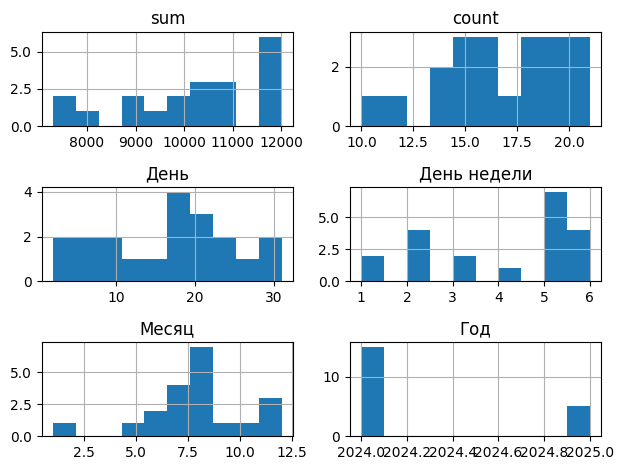

In [16]:
day_data.sort_values('sum').head(20).hist()
plt.tight_layout()
plt.show()

Ещё раз увидели ту же статистику. Самые провальные дни - выходные и 16-24 числа месяца. Самыё провальные месяца - июль, август. То есть люди отдыхают в жаркие месяцы и выходные вместо того, чтобы идти к нам. Нужно создать благоприятные условия для отдыха в магазине - кондиционер, диваны, музыка.